# 🤖 RL Agent Training with PPO

**Purpose:** Train a Reinforcement Learning agent using Proximal Policy Optimization (PPO) to learn optimal pricing.

**What we'll do:**
1. Import the DynamicPricingEnv from previous notebook
2. Initialize PPO agent from Stable-Baselines3
3. Train the agent for multiple timesteps
4. Save the trained model
5. Visualize learning progress

---

## 1. Import Required Libraries

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import os

np.random.seed(42)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Copy DynamicPricingEnv Class

We need to redefine the environment class in this notebook.

In [2]:
class DynamicPricingEnv(gym.Env):
    """Custom Gym Environment for Dynamic Pricing"""
    
    def __init__(self, max_days=365):
        super(DynamicPricingEnv, self).__init__()
        
        self.max_days = max_days
        self.current_day = 0
        self.last_price = 100
        
        self.min_price = 50
        self.max_price = 150
        self.price_step = 10
        self.prices = np.arange(self.min_price, self.max_price + 1, self.price_step)
        
        self.base_demand = 1000
        self.optimal_price = 100
        self.price_elasticity = -1.5
        
        self.action_space = spaces.Discrete(len(self.prices))
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]),
            high=np.array([1, 1, 1]),
            dtype=np.float32
        )
        
    def _get_competitor_price(self):
        competitor_price = self.optimal_price + np.random.normal(0, 15)
        return np.clip(competitor_price, self.min_price, self.max_price)
    
    def _get_seasonal_factor(self):
        return 1 + 0.3 * np.sin(2 * np.pi * self.current_day / 365)
    
    def _calculate_demand(self, price, competitor_price):
        price_ratio = price / self.optimal_price
        elasticity_effect = np.power(price_ratio, self.price_elasticity)
        seasonal_factor = self._get_seasonal_factor()
        competitor_effect = 1 - 0.2 * (competitor_price < price)
        demand = self.base_demand * elasticity_effect * seasonal_factor * competitor_effect
        noise = np.random.normal(1, 0.1)
        demand = demand * noise
        return max(0, demand)
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_day = 0
        self.last_price = 100
        observation = self._get_observation()
        info = {}
        return observation, info
    
    def _get_observation(self):
        competitor_price = self._get_competitor_price()
        obs = np.array([
            self.current_day / self.max_days,
            (self.last_price - self.min_price) / (self.max_price - self.min_price),
            (competitor_price - self.min_price) / (self.max_price - self.min_price)
        ], dtype=np.float32)
        return obs
    
    def step(self, action):
        price = self.prices[action]
        competitor_price = self._get_competitor_price()
        demand = self._calculate_demand(price, competitor_price)
        revenue = price * demand
        reward = revenue / 1000
        
        self.last_price = price
        self.current_day += 1
        
        terminated = self.current_day >= self.max_days
        truncated = False
        observation = self._get_observation()
        
        info = {
            'price': price,
            'demand': demand,
            'revenue': revenue,
            'competitor_price': competitor_price,
            'day': self.current_day
        }
        
        return observation, reward, terminated, truncated, info

print("✅ DynamicPricingEnv class defined!")

✅ DynamicPricingEnv class defined!


## 3. Create Custom Callback for Training Visualization

This callback will track rewards during training.

In [3]:
class RewardCallback(BaseCallback):
    """
    Custom callback for tracking rewards during training
    """
    def __init__(self, verbose=0):
        super(RewardCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []
        self.current_rewards = []
        
    def _on_step(self):
        # Get the last reward
        reward = self.locals['rewards'][0]
        self.current_rewards.append(reward)
        
        # Check if episode is done
        done = self.locals['dones'][0]
        if done:
            episode_reward = sum(self.current_rewards)
            episode_length = len(self.current_rewards)
            
            self.episode_rewards.append(episode_reward)
            self.episode_lengths.append(episode_length)
            self.current_rewards = []
            
            if self.verbose > 0:
                print(f"Episode {len(self.episode_rewards)}: Reward = {episode_reward:.2f}, Length = {episode_length}")
        
        return True

print("✅ RewardCallback class defined!")

✅ RewardCallback class defined!


## 4. Initialize Environment and PPO Agent

In [4]:
# Create environment
env = DynamicPricingEnv(max_days=365)

print("🎮 Environment created!")
print(f"   Action Space: {env.action_space}")
print(f"   Observation Space: {env.observation_space}")

# Initialize PPO agent
model = PPO(
    "MlpPolicy",  # Multi-Layer Perceptron policy
    env,
    learning_rate=0.0003,
    n_steps=2048,
    batch_size=64,
    n_epochs=10,
    gamma=0.99,
    verbose=1,
    seed=42
)

print("\n🤖 PPO Agent initialized!")
print(f"   Policy: MlpPolicy")
print(f"   Learning Rate: 0.0003")
print(f"   Gamma (Discount Factor): 0.99")

🎮 Environment created!
   Action Space: Discrete(11)
   Observation Space: Box(0.0, 1.0, (3,), float32)
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.



🤖 PPO Agent initialized!
   Policy: MlpPolicy
   Learning Rate: 0.0003
   Gamma (Discount Factor): 0.99


## 5. Train the Agent

Training for 100,000 timesteps (approximately 273 episodes with 365 days each).

In [5]:
# Create callback
callback = RewardCallback(verbose=0)

# Train the model
print("🚀 Starting training...")
print("   Total timesteps: 100,000")
print("   This may take a few minutes...\n")

TOTAL_TIMESTEPS = 100_000

model.learn(
    total_timesteps=TOTAL_TIMESTEPS,
    callback=callback,
    progress_bar=True
)

print("\nTraining completed!")
print(f"   Total episodes: {len(callback.episode_rewards)}")
print(f"   Average reward: {np.mean(callback.episode_rewards):.2f}")

Output()

🚀 Starting training...
   Total timesteps: 100,000
   This may take a few minutes...



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 365      |
|    ep_rew_mean     | 3.5e+04  |
| time/              |          |
|    fps             | 7617     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.49e+04      |
| time/                   |               |
|    fps                  | 5507          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.00012812097 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.4          |
|    explained_variance   | 0.000124      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.28e+06      |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000922     |
|    value_loss           | 2.56e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.48e+04      |
| time/                   |               |
|    fps                  | 5058          |
|    iterations           | 3             |
|    time_elapsed         | 1             |
|    total_timesteps      | 6144          |
| train/                  |               |
|    approx_kl            | 5.6534394e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.4          |
|    explained_variance   | -0.00162      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.14e+06      |
|    n_updates            | 20            |
|    policy_gradient_loss | -0.000592     |
|    value_loss           | 2.43e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.49e+04      |
| time/                   |               |
|    fps                  | 4868          |
|    iterations           | 4             |
|    time_elapsed         | 1             |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 2.8161157e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.4          |
|    explained_variance   | -0.000453     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.24e+06      |
|    n_updates            | 30            |
|    policy_gradient_loss | -0.000271     |
|    value_loss           | 2.44e+06      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.5e+04      |
| time/                   |              |
|    fps                  | 4785         |
|    iterations           | 5            |
|    time_elapsed         | 2            |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 4.455939e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.4         |
|    explained_variance   | -0.000238    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.29e+06     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.000422    |
|    value_loss           | 2.57e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.5e+04      |
| time/                   |              |
|    fps                  | 4723         |
|    iterations           | 6            |
|    time_elapsed         | 2            |
|    total_timesteps      | 12288        |
| train/                  |              |
|    approx_kl            | 6.628179e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.4         |
|    explained_variance   | -0.000148    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.25e+06     |
|    n_updates            | 50           |
|    policy_gradient_loss | -0.000641    |
|    value_loss           | 2.42e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.5e+04      |
| time/                   |              |
|    fps                  | 4690         |
|    iterations           | 7            |
|    time_elapsed         | 3            |
|    total_timesteps      | 14336        |
| train/                  |              |
|    approx_kl            | 6.433195e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.4         |
|    explained_variance   | -0.000103    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.24e+06     |
|    n_updates            | 60           |
|    policy_gradient_loss | -0.000626    |
|    value_loss           | 2.52e+06     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.5e+04       |
| time/                   |               |
|    fps                  | 4665          |
|    iterations           | 8             |
|    time_elapsed         | 3             |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 7.4269425e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.4          |
|    explained_variance   | -6.6e-05      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+06      |
|    n_updates            | 70            |
|    policy_gradient_loss | -0.000658     |
|    value_loss           | 2.47e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.51e+04      |
| time/                   |               |
|    fps                  | 4628          |
|    iterations           | 9             |
|    time_elapsed         | 3             |
|    total_timesteps      | 18432         |
| train/                  |               |
|    approx_kl            | 3.9588398e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.4          |
|    explained_variance   | -5.01e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.28e+06      |
|    n_updates            | 80            |
|    policy_gradient_loss | -0.000365     |
|    value_loss           | 2.49e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.51e+04      |
| time/                   |               |
|    fps                  | 4605          |
|    iterations           | 10            |
|    time_elapsed         | 4             |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 4.7174195e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.4          |
|    explained_variance   | -3.95e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.06e+06      |
|    n_updates            | 90            |
|    policy_gradient_loss | -0.000442     |
|    value_loss           | 2.52e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.51e+04      |
| time/                   |               |
|    fps                  | 4583          |
|    iterations           | 11            |
|    time_elapsed         | 4             |
|    total_timesteps      | 22528         |
| train/                  |               |
|    approx_kl            | 6.6306355e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.4          |
|    explained_variance   | -2.66e-05     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.4e+06       |
|    n_updates            | 100           |
|    policy_gradient_loss | -0.000612     |
|    value_loss           | 2.52e+06      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.52e+04     |
| time/                   |              |
|    fps                  | 4573         |
|    iterations           | 12           |
|    time_elapsed         | 5            |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 4.662221e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.39        |
|    explained_variance   | -1.9e-05     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.04e+06     |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.000438    |
|    value_loss           | 2.53e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.52e+04     |
| time/                   |              |
|    fps                  | 4555         |
|    iterations           | 13           |
|    time_elapsed         | 5            |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 8.436112e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.39        |
|    explained_variance   | -1.68e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.44e+06     |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00075     |
|    value_loss           | 2.53e+06     |
------------------------------------------


--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 365            |
|    ep_rew_mean          | 3.52e+04       |
| time/                   |                |
|    fps                  | 4551           |
|    iterations           | 14             |
|    time_elapsed         | 6              |
|    total_timesteps      | 28672          |
| train/                  |                |
|    approx_kl            | 0.000113597256 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -2.39          |
|    explained_variance   | -1.32e-05      |
|    learning_rate        | 0.0003         |
|    loss                 | 1.13e+06       |
|    n_updates            | 130            |
|    policy_gradient_loss | -0.000936      |
|    value_loss           | 2.44e+06       |
--------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.52e+04     |
| time/                   |              |
|    fps                  | 4544         |
|    iterations           | 15           |
|    time_elapsed         | 6            |
|    total_timesteps      | 30720        |
| train/                  |              |
|    approx_kl            | 6.664323e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.39        |
|    explained_variance   | -1.08e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.26e+06     |
|    n_updates            | 140          |
|    policy_gradient_loss | -0.000675    |
|    value_loss           | 2.59e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.52e+04     |
| time/                   |              |
|    fps                  | 4527         |
|    iterations           | 16           |
|    time_elapsed         | 7            |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 5.610028e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.39        |
|    explained_variance   | -8.7e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22e+06     |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.000536    |
|    value_loss           | 2.47e+06     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.53e+04      |
| time/                   |               |
|    fps                  | 4522          |
|    iterations           | 17            |
|    time_elapsed         | 7             |
|    total_timesteps      | 34816         |
| train/                  |               |
|    approx_kl            | 6.8958616e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.39         |
|    explained_variance   | -6.08e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.41e+06      |
|    n_updates            | 160           |
|    policy_gradient_loss | -0.000632     |
|    value_loss           | 2.5e+06       |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.53e+04      |
| time/                   |               |
|    fps                  | 4517          |
|    iterations           | 18            |
|    time_elapsed         | 8             |
|    total_timesteps      | 36864         |
| train/                  |               |
|    approx_kl            | 6.0915772e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.39         |
|    explained_variance   | -6.32e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.08e+06      |
|    n_updates            | 170           |
|    policy_gradient_loss | -0.000591     |
|    value_loss           | 2.54e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.53e+04      |
| time/                   |               |
|    fps                  | 4510          |
|    iterations           | 19            |
|    time_elapsed         | 8             |
|    total_timesteps      | 38912         |
| train/                  |               |
|    approx_kl            | 6.8475492e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.39         |
|    explained_variance   | -4.77e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.19e+06      |
|    n_updates            | 180           |
|    policy_gradient_loss | -8.84e-05     |
|    value_loss           | 2.52e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.54e+04      |
| time/                   |               |
|    fps                  | 4499          |
|    iterations           | 20            |
|    time_elapsed         | 9             |
|    total_timesteps      | 40960         |
| train/                  |               |
|    approx_kl            | 0.00012233082 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.39         |
|    explained_variance   | -4.17e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.23e+06      |
|    n_updates            | 190           |
|    policy_gradient_loss | -0.00106      |
|    value_loss           | 2.6e+06       |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.55e+04      |
| time/                   |               |
|    fps                  | 4486          |
|    iterations           | 21            |
|    time_elapsed         | 9             |
|    total_timesteps      | 43008         |
| train/                  |               |
|    approx_kl            | 3.2295648e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.39         |
|    explained_variance   | -3.46e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.17e+06      |
|    n_updates            | 200           |
|    policy_gradient_loss | -0.000285     |
|    value_loss           | 2.52e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.55e+04      |
| time/                   |               |
|    fps                  | 4482          |
|    iterations           | 22            |
|    time_elapsed         | 10            |
|    total_timesteps      | 45056         |
| train/                  |               |
|    approx_kl            | 0.00010982313 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.39         |
|    explained_variance   | -2.62e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 210           |
|    policy_gradient_loss | -0.000953     |
|    value_loss           | 2.54e+06      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.56e+04     |
| time/                   |              |
|    fps                  | 4473         |
|    iterations           | 23           |
|    time_elapsed         | 10           |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 4.237893e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.38        |
|    explained_variance   | -2.15e-06    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.33e+06     |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.000373    |
|    value_loss           | 2.67e+06     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.57e+04      |
| time/                   |               |
|    fps                  | 4467          |
|    iterations           | 24            |
|    time_elapsed         | 11            |
|    total_timesteps      | 49152         |
| train/                  |               |
|    approx_kl            | 4.5857014e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.38         |
|    explained_variance   | -1.55e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.38e+06      |
|    n_updates            | 230           |
|    policy_gradient_loss | -0.000379     |
|    value_loss           | 2.49e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.57e+04      |
| time/                   |               |
|    fps                  | 4468          |
|    iterations           | 25            |
|    time_elapsed         | 11            |
|    total_timesteps      | 51200         |
| train/                  |               |
|    approx_kl            | 6.0265622e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.38         |
|    explained_variance   | -1.79e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.32e+06      |
|    n_updates            | 240           |
|    policy_gradient_loss | -0.000521     |
|    value_loss           | 2.71e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.58e+04      |
| time/                   |               |
|    fps                  | 4471          |
|    iterations           | 26            |
|    time_elapsed         | 11            |
|    total_timesteps      | 53248         |
| train/                  |               |
|    approx_kl            | 3.3193588e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.38         |
|    explained_variance   | -1.31e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.07e+06      |
|    n_updates            | 250           |
|    policy_gradient_loss | -0.000289     |
|    value_loss           | 2.5e+06       |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.58e+04      |
| time/                   |               |
|    fps                  | 4470          |
|    iterations           | 27            |
|    time_elapsed         | 12            |
|    total_timesteps      | 55296         |
| train/                  |               |
|    approx_kl            | 4.8840186e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.38         |
|    explained_variance   | -1.31e-06     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.45e+06      |
|    n_updates            | 260           |
|    policy_gradient_loss | -0.000465     |
|    value_loss           | 2.57e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.59e+04      |
| time/                   |               |
|    fps                  | 4472          |
|    iterations           | 28            |
|    time_elapsed         | 12            |
|    total_timesteps      | 57344         |
| train/                  |               |
|    approx_kl            | 4.9575232e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.38         |
|    explained_variance   | -9.54e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+06      |
|    n_updates            | 270           |
|    policy_gradient_loss | -0.00043      |
|    value_loss           | 2.64e+06      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.59e+04     |
| time/                   |              |
|    fps                  | 4475         |
|    iterations           | 29           |
|    time_elapsed         | 13           |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 7.210413e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.38        |
|    explained_variance   | -7.15e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.29e+06     |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.000621    |
|    value_loss           | 2.48e+06     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.6e+04       |
| time/                   |               |
|    fps                  | 4475          |
|    iterations           | 30            |
|    time_elapsed         | 13            |
|    total_timesteps      | 61440         |
| train/                  |               |
|    approx_kl            | 3.9589242e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.38         |
|    explained_variance   | -9.54e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.47e+06      |
|    n_updates            | 290           |
|    policy_gradient_loss | -0.000295     |
|    value_loss           | 2.67e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.61e+04      |
| time/                   |               |
|    fps                  | 4475          |
|    iterations           | 31            |
|    time_elapsed         | 14            |
|    total_timesteps      | 63488         |
| train/                  |               |
|    approx_kl            | 5.0254457e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.38         |
|    explained_variance   | -8.34e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.4e+06       |
|    n_updates            | 300           |
|    policy_gradient_loss | -0.000424     |
|    value_loss           | 2.6e+06       |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.61e+04     |
| time/                   |              |
|    fps                  | 4474         |
|    iterations           | 32           |
|    time_elapsed         | 14           |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 2.386127e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.37        |
|    explained_variance   | -7.15e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.25e+06     |
|    n_updates            | 310          |
|    policy_gradient_loss | -0.000208    |
|    value_loss           | 2.58e+06     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.62e+04      |
| time/                   |               |
|    fps                  | 4477          |
|    iterations           | 33            |
|    time_elapsed         | 15            |
|    total_timesteps      | 67584         |
| train/                  |               |
|    approx_kl            | 0.00010156236 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.37         |
|    explained_variance   | -5.96e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.39e+06      |
|    n_updates            | 320           |
|    policy_gradient_loss | -0.000781     |
|    value_loss           | 2.68e+06      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.63e+04     |
| time/                   |              |
|    fps                  | 4476         |
|    iterations           | 34           |
|    time_elapsed         | 15           |
|    total_timesteps      | 69632        |
| train/                  |              |
|    approx_kl            | 5.656478e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.37        |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.19e+06     |
|    n_updates            | 330          |
|    policy_gradient_loss | -0.00039     |
|    value_loss           | 2.55e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.63e+04     |
| time/                   |              |
|    fps                  | 4477         |
|    iterations           | 35           |
|    time_elapsed         | 16           |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 4.525698e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.37        |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.23e+06     |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.000378    |
|    value_loss           | 2.68e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.64e+04     |
| time/                   |              |
|    fps                  | 4476         |
|    iterations           | 36           |
|    time_elapsed         | 16           |
|    total_timesteps      | 73728        |
| train/                  |              |
|    approx_kl            | 4.842496e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.37        |
|    explained_variance   | -3.58e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.19e+06     |
|    n_updates            | 350          |
|    policy_gradient_loss | -0.000383    |
|    value_loss           | 2.64e+06     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 365         |
|    ep_rew_mean          | 3.65e+04    |
| time/                   |             |
|    fps                  | 4473        |
|    iterations           | 37          |
|    time_elapsed         | 16          |
|    total_timesteps      | 75776       |
| train/                  |             |
|    approx_kl            | 8.29997e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.22e+06    |
|    n_updates            | 360         |
|    policy_gradient_loss | -0.000654   |
|    value_loss           | 2.65e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 365         |
|    ep_rew_mean          | 3.66e+04    |
| time/                   |             |
|    fps                  | 4472        |
|    iterations           | 38          |
|    time_elapsed         | 17          |
|    total_timesteps      | 77824       |
| train/                  |             |
|    approx_kl            | 6.11413e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | -2.38e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.37e+06    |
|    n_updates            | 370         |
|    policy_gradient_loss | -0.000547   |
|    value_loss           | 2.73e+06    |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 365         |
|    ep_rew_mean          | 3.66e+04    |
| time/                   |             |
|    fps                  | 4473        |
|    iterations           | 39          |
|    time_elapsed         | 17          |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 9.90055e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.36       |
|    explained_variance   | -3.58e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.31e+06    |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.000676   |
|    value_loss           | 2.63e+06    |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.67e+04     |
| time/                   |              |
|    fps                  | 4471         |
|    iterations           | 40           |
|    time_elapsed         | 18           |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 7.827752e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.36        |
|    explained_variance   | -2.38e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.18e+06     |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.000509    |
|    value_loss           | 2.68e+06     |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.68e+04      |
| time/                   |               |
|    fps                  | 4472          |
|    iterations           | 41            |
|    time_elapsed         | 18            |
|    total_timesteps      | 83968         |
| train/                  |               |
|    approx_kl            | 4.6516943e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.35         |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.43e+06      |
|    n_updates            | 400           |
|    policy_gradient_loss | -0.000324     |
|    value_loss           | 2.71e+06      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.68e+04     |
| time/                   |              |
|    fps                  | 4471         |
|    iterations           | 42           |
|    time_elapsed         | 19           |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 7.770941e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.35        |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.42e+06     |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.000535    |
|    value_loss           | 2.63e+06     |
------------------------------------------


--------------------------------------------
| rollout/                |                |
|    ep_len_mean          | 365            |
|    ep_rew_mean          | 3.69e+04       |
| time/                   |                |
|    fps                  | 4471           |
|    iterations           | 43             |
|    time_elapsed         | 19             |
|    total_timesteps      | 88064          |
| train/                  |                |
|    approx_kl            | 0.000108147564 |
|    clip_fraction        | 0              |
|    clip_range           | 0.2            |
|    entropy_loss         | -2.35          |
|    explained_variance   | -1.19e-07      |
|    learning_rate        | 0.0003         |
|    loss                 | 1.48e+06       |
|    n_updates            | 420            |
|    policy_gradient_loss | -0.000604      |
|    value_loss           | 2.85e+06       |
--------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 365         |
|    ep_rew_mean          | 3.7e+04     |
| time/                   |             |
|    fps                  | 4469        |
|    iterations           | 44          |
|    time_elapsed         | 20          |
|    total_timesteps      | 90112       |
| train/                  |             |
|    approx_kl            | 4.73462e-05 |
|    clip_fraction        | 0           |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.35       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | 1.26e+06    |
|    n_updates            | 430         |
|    policy_gradient_loss | -0.000337   |
|    value_loss           | 2.65e+06    |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.71e+04      |
| time/                   |               |
|    fps                  | 4467          |
|    iterations           | 45            |
|    time_elapsed         | 20            |
|    total_timesteps      | 92160         |
| train/                  |               |
|    approx_kl            | 0.00011790317 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.34         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.49e+06      |
|    n_updates            | 440           |
|    policy_gradient_loss | -0.000783     |
|    value_loss           | 2.73e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.72e+04      |
| time/                   |               |
|    fps                  | 4468          |
|    iterations           | 46            |
|    time_elapsed         | 21            |
|    total_timesteps      | 94208         |
| train/                  |               |
|    approx_kl            | 4.7640817e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.34         |
|    explained_variance   | -1.19e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.44e+06      |
|    n_updates            | 450           |
|    policy_gradient_loss | -0.000335     |
|    value_loss           | 2.88e+06      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 365           |
|    ep_rew_mean          | 3.72e+04      |
| time/                   |               |
|    fps                  | 4470          |
|    iterations           | 47            |
|    time_elapsed         | 21            |
|    total_timesteps      | 96256         |
| train/                  |               |
|    approx_kl            | 0.00014878053 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.34         |
|    explained_variance   | -2.38e-07     |
|    learning_rate        | 0.0003        |
|    loss                 | 1.26e+06      |
|    n_updates            | 460           |
|    policy_gradient_loss | -0.000876     |
|    value_loss           | 2.64e+06      |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.73e+04     |
| time/                   |              |
|    fps                  | 4469         |
|    iterations           | 48           |
|    time_elapsed         | 21           |
|    total_timesteps      | 98304        |
| train/                  |              |
|    approx_kl            | 0.0001585256 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.33        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 1.43e+06     |
|    n_updates            | 470          |
|    policy_gradient_loss | -0.00097     |
|    value_loss           | 2.76e+06     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 365          |
|    ep_rew_mean          | 3.74e+04     |
| time/                   |              |
|    fps                  | 4468         |
|    iterations           | 49           |
|    time_elapsed         | 22           |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 6.688904e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.33        |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.38e+06     |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.000431    |
|    value_loss           | 2.75e+06     |
------------------------------------------



Training completed!
   Total episodes: 274
   Average reward: 36317.75


## 6. Visualize Learning Progress

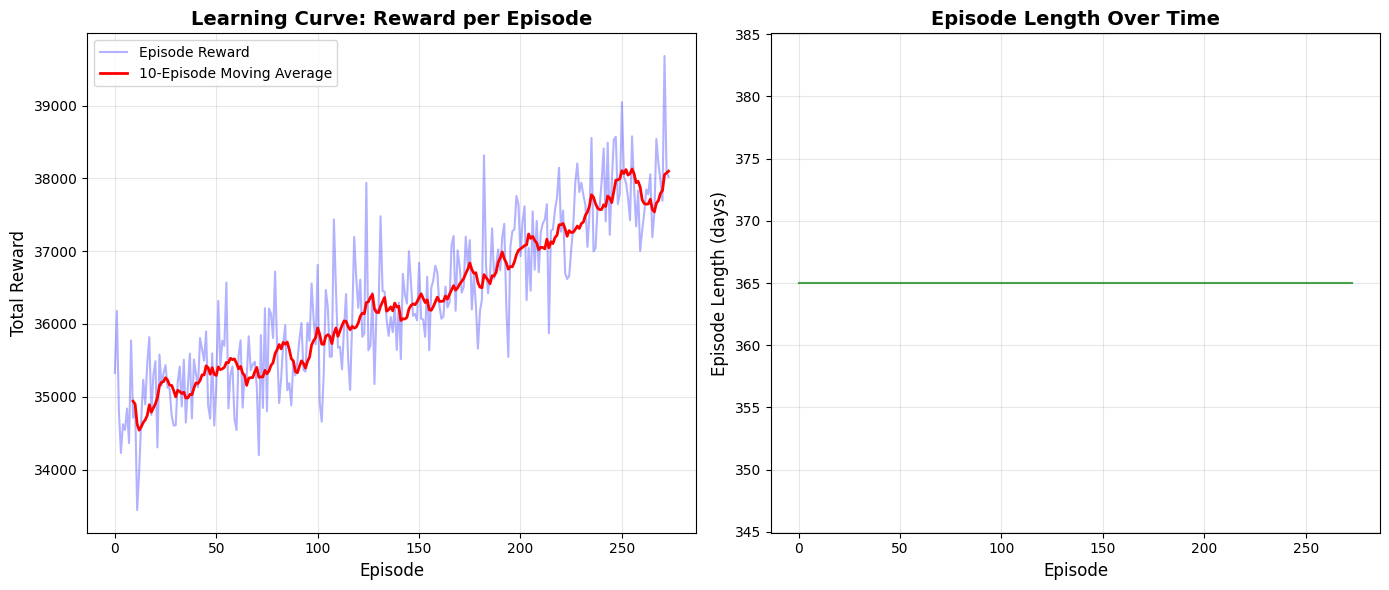

✅ Learning curve saved to visuals/reward_curve.png


In [6]:
# Plot learning curve
plt.figure(figsize=(14, 6))

# Moving average window
window = 10
rewards_smooth = np.convolve(callback.episode_rewards, np.ones(window)/window, mode='valid')

plt.subplot(1, 2, 1)
plt.plot(callback.episode_rewards, alpha=0.3, color='blue', label='Episode Reward')
plt.plot(range(window-1, len(callback.episode_rewards)), rewards_smooth, 
         color='red', linewidth=2, label=f'{window}-Episode Moving Average')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Total Reward', fontsize=12)
plt.title('Learning Curve: Reward per Episode', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(callback.episode_lengths, alpha=0.7, color='green')
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Episode Length (days)', fontsize=12)
plt.title('Episode Length Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visuals/reward_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Learning curve saved to visuals/reward_curve.png")

## 7. Save the Trained Model

In [7]:
# Save the trained model
model_path = '../saved_models/pricing_agent_ppo'
model.save(model_path)

print(f"✅ Model saved successfully to: {model_path}.zip")
print(f"💾 File size: {os.path.getsize(model_path + '.zip') / 1024:.2f} KB")
print("\n🎉 Training complete! The agent is ready for evaluation.")

✅ Model saved successfully to: ../saved_models/pricing_agent_ppo.zip
💾 File size: 143.79 KB

🎉 Training complete! The agent is ready for evaluation.
